In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## AdaLiNe GD

In [4]:
class AdaLiNeGD:
    def __init__(self, lr = 0.01, n_iter = 50):
        self.lr = lr # Taza de aprendizaje
        self.n_iter = n_iter

    def fit(self, X, y):        
        self.w_ = np.zeros(1 + X.shape[1]) # Iniciar con pesos en 0
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X) # Recortado debido a que se usa f(x) = x
            errors = (y - output) # Calcula el error
            self.w_[1:] += self.lr * X.T.dot(errors) # Cambia los pesos, X.T.dot(errors) = derivada parcial?
            self.w_[0] += self.lr * errors.sum() # que hace w0?...
            cost = (errors**2).sum() / 2.0 # calcula el coste
            self.cost_.append(cost) # guarda el coste
        return self

    def net_input(self, X): # Esto es calcular z
        return np.dot(X, self.w_[1:]) + self.w_[0] 

    def predict(self, X):
        # self.activation(self.net_input(X)) -> self.net_input(X)
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### AdaLiNe GD - Notas

#### fit

* Recorté toda la parte de la función de activación porque entiendo que no influye en nada, segun Rashka, es algo simbolico para, más adelante, cambiarlo por regresion logistica.  
    Veo que tambien se usa en predict, también lo recorté ahí.
* Creo que no comprendo lo que hace la parte "errors = (y - output)"  
    Creo que ya entiendo, es como la otra vez, si el output es diferente a y entonces ahi es cuando se aclcula el error.  
    Ya entiendo de dode surge, es parte de la derivada parcial.
* en la parte de "X.T.dot(errors)", yo entiendo que todo eso es el calculo de la derivada parcial.
* Entender como se involucra w0 me cuesta trabajo, creo que tengo que ponerle mas atencion.  
    Ahora que lo pienso, w0 es el limite de activación(o algo asi)... <- __Investigar sobre eso__

## Dataset

Se obtienen los datos del detaset

In [7]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header = None, encoding = 'utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### y

In [10]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

### X

In [11]:
X = df.iloc[0:100, [0, 2]].values

### Estandarizando x

In [28]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

## Entrenando

In [29]:
ada_gd = AdaLiNeGD(lr = 0.01, n_iter = 10)
ada_gd.fit(X_std, y)

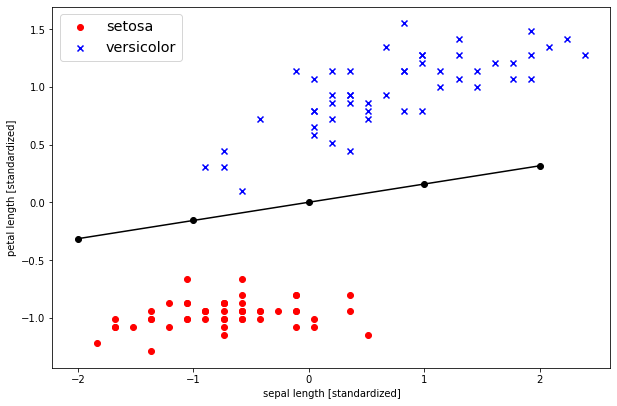

In [65]:
fig, ax = plt.subplots(figsize = [10,8])

#fig.suptitle('', fontsize = 26)

ax.set_aspect(aspect = 1)

ax.set_xlabel('sepal length [standardized]')
ax.set_ylabel('petal length [standardized]')

ax.scatter(
    X_std[:50, 0], 
    X_std[:50, 1], 
    color = 'red', 
    marker = 'o', 
    label = 'setosa'
)

ax.scatter(
    X_std[50:100, 0], 
    X_std[50:100, 1],
    color = 'blue', 
    marker = 'x', 
    label = 'versicolor'
)

ws = ada_gd.w_
plt.plot(
    list(range(-2, 3)), 
    [(-ws[0] -(ws[1]*x))/ws[2] for x in range(-2,3)], 
    marker = 'o',
    color = 'black'
)

plt.legend(fontsize = 'x-large')

Text(0, 0.5, 'Sum-squared-error')

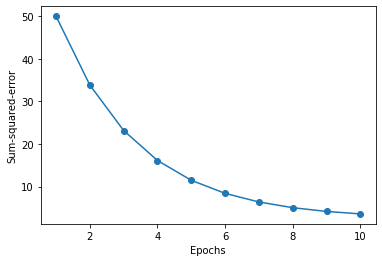

In [66]:
plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

El descenso clasico es muy costoso para datets con millones de lineas, por eso se usa adline con descenso de gradiente estocastico o hacer descenso normal pero a pedazos.

In [67]:
from numpy.random import seed

In [70]:
class AdaLiNeSGD:
    def __init__(self, 
                 lr = 0.01, 
                 n_iter = 10, 
                 shuffle = True, 
                 random_state = None
                ):
        self.lr = lr
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle # Por la explicación de Rashka, no entiendo porque dar posibilidad a False
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y): # se modifican los pesos por cada linea de datos
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y): # Esto es para actualizar pesos sin borrar los anteriores
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1: # Ehhh, no entiendo que hace, creo que es para evitar arrays vacios
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc = 0.0, scale = 0.01, size = 1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target): # esto es la actualización parcial
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.lr * xi.dot(error)
        self.w_[0] += self.lr * error # no se hacec la sumatoria de errores porque solo hay uno
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Notas adaline estocastica.

* En esta también removi la funcion de activación
* ¿No se podrá hacer una adaline normal y estocastica en una sola clase?, supongo que sí pero debe ser muy complicado como para que valga la pena.
* !!! Añadir un lr que se adapte con el tiempo puede mejorar el ajuste. Lr que se reduce con el tiempo.  
    en realidad se reduce con el número de actualizaciones, no?, supongo que eso varía  
    tal vez se reduce cada x actualizaciones, lineal o de otra manera  

In [72]:
ada_sgd = AdaLiNeSGD(n_iter = 15, lr = 0.01, random_state = 1)
ada_sgd.fit(X_std, y)

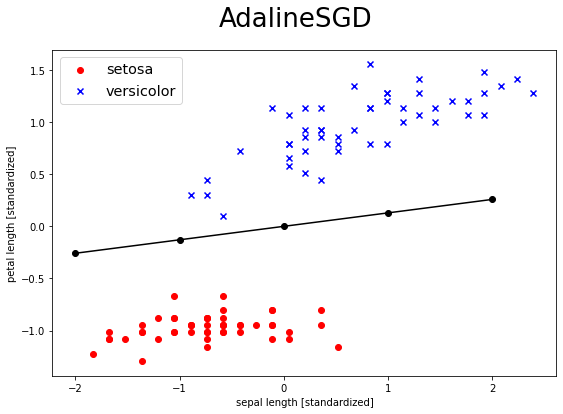

In [82]:
fig, ax = plt.subplots(figsize = [10,6])

fig.suptitle('AdalineSGD', fontsize = 26)

ax.set_aspect(aspect = 1)

ax.set_xlabel('sepal length [standardized]')
ax.set_ylabel('petal length [standardized]')

ax.scatter(
    X_std[:50, 0], 
    X_std[:50, 1], 
    color = 'red', 
    marker = 'o', 
    label = 'setosa'
)

ax.scatter(
    X_std[50:100, 0], 
    X_std[50:100, 1],
    color = 'blue', 
    marker = 'x', 
    label = 'versicolor'
)

ws = ada_sgd.w_
plt.plot(
    list(range(-2, 3)), 
    [(-ws[0] -(ws[1]*x))/ws[2] for x in range(-2,3)], 
    marker = 'o',
    color = 'black'
)

plt.legend(fontsize = 'x-large')

In [80]:
print(ada_sgd.w_)
print(ada_gd.w_)
print(ada_sgd.w_ - ada_gd.w_)
# Mm... no deberian ser casi iguales?, la diferencia de los ultimos numeros es casi 1 -> error, es casi 0.1
# aun asi pense que sería menor

[ 2.27202773e-04 -1.38544756e-01  1.07263215e+00]
[ 3.40838469e-16 -1.53568950e-01  9.73264237e-01]
[0.0002272  0.01502419 0.09936792]
